In [10]:
import openpyxl
import math
from math import log
import os
import scipy
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt


def HowManyElementsInG(vector, n, e):
    array_ind_g = np.zeros(len(vector))
    array_ind_g[0] = 1
    for i in range(1, len(vector) - n):
        i_is_in_G = True
        for j in range(i):
            if array_ind_g[j] == 1:
                temp_max = max(np.absolute(vector[i: i + n + 1] - vector[j: j + n + 1]))
                if(temp_max < e):
                    i_is_in_G = False
                    break
        if(i_is_in_G is True):
            array_ind_g[i] = 1
    #print(array_ind_g)
    return int(sum(array_ind_g))

def FindSpecFunkValue(vector, n, e):
    C_n_e = HowManyElementsInG(vector, n, e)
    if (C_n_e == 0):
        print("C = 0")
        rez = 0
    else:
        rez = log(C_n_e) / (n - log(e))
    return rez

def FindManyValuesInVector(vector, n, e, proc_decriese, counte):
    array = []
    for i in range(counte):
        array.append(FindSpecFunkValue(vector, n, e))
        e *= (1-proc_decriese )
    return array

def FindTackensKoefInMatrix(name, n, e):
    matrix = []
    wb = openpyxl.load_workbook(filename=name)
    sheet = wb['Fract_4000']
    for j in range(2,331):
        tempEl = []
        for i in range(3,1623):
            tempEl.append(sheet.cell(row=i, column=j).value)
        matrix.append(tempEl)
    otv = FindC_n_e(matrix, n, e)
    print(otv)
    return 0

number of el in Cne in /content/drive/MyDrive/Алюминий 1 серия.xlsx = 1


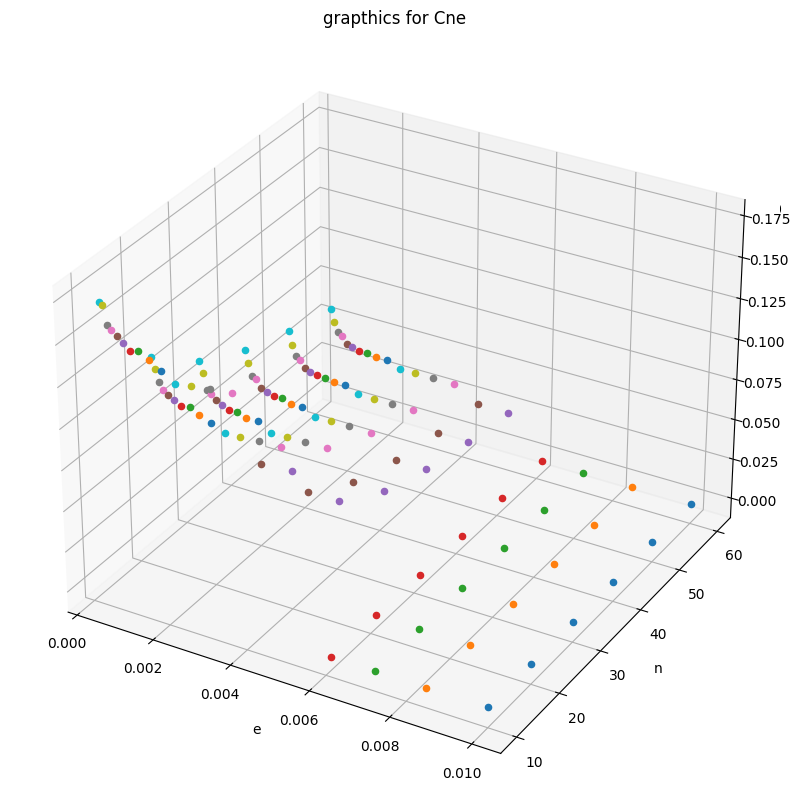

In [17]:
import openpyxl
import math
import os
import scipy
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
#import TackensMethof as tm
from mpl_toolkits.mplot3d import Axes3D

def ChemistryKoef(name_of_file, new_file_name):
    wb = openpyxl.load_workbook(filename=name_of_file)
    sheet = wb['1']
    massivF = []
    x1,y1 = 2, 3
    array_name_length = []
    while True:
        if sheet.cell(row=x1, column=y1).value == None:
            break
        try:
            if int(sheet.cell(row=x1+1, column=y1).value) > int(sheet.cell(row=x1+1, column=y1+1).value):
                t = []
                t.append('_'.join(str(sheet.cell(row=x1, column=y1).value).split('_')[:-1]))
                t.append(int(sheet.cell(row=x1+1, column=y1).value))
                array_name_length.append(t)
        except TypeError:
            t = []
            t.append('_'.join(str(sheet.cell(row=x1, column=y1).value).split('_')[:-1]))
            t.append(int(sheet.cell(row=x1 + 1, column=y1).value))
            array_name_length.append(t)
        y1 += 1
    array_name_length = np.array(array_name_length)

    for r in range(len(array_name_length)): # проходимся по растворам
        massivF.append([])
        for j in range(int(array_name_length[r][1])):# цикл для прохода по столбцам
            massivF[r].append([])
            temp = [0]
            start_i = 4
            i = start_i # это строчка с которой начинаются коэффициенты
            while sheet.cell(row=i, column=j + 3 + r * 100).value != None:
                temp.append(sheet.cell(row=i, column=j + 3 + r * 100).value)
                i += 1

            fc = 0; fs = 0;
            t = i - start_i; l = t /2; omega = math.pi / l

            f0 = sum(temp) * 2 / t
            massivF[r][j].append(f0)
            for k in range(1, 6):
                # считываем fkc
                for i in range(t + 1):
                    fc += temp[i] * math.cos(omega * i * k)
                fc = (fc * 2) / t
                massivF[r][j].append(fc)
                fc = 0
                # считываем fks
                for i in range(t+1):
                    fs += temp[i] * math.sin(omega * i * k)
                fs = (fs * 2) / t
                massivF[r][j].append(fs)
                fs = 0
    # мы считали все элементы f0,f1c,f1s и т.д. в j элемент массива MassivF то есть 11 коэфициентов
    newwb = openpyxl.Workbook()
    ws = newwb.active
    for r in range(len(array_name_length)):
        name = ws.cell(row=1 + r * 12, column=1)
        name.value = array_name_length[r][0]
        for i in range(len(massivF[0])):#количество столбцов
            for j in range(len(massivF[0][i])):
                b = ws.cell(row=r * 12 + j + 1, column=i + 2)
                b.value = massivF[r][i][j]
    if os.path.isfile(new_file_name):
        os.remove(new_file_name)
    newwb.save(filename=new_file_name)
    print(f'Programm is done')

def GetMatrix(name, num):#надо убрать зависимость от t!
    wb = openpyxl.load_workbook(filename= name )
    sheet = wb['Sheet']
    massivF = []
    for j in range(100):
        tempEl = []
        for i in range(1, 12):
            tempEl.append(sheet.cell(row=i + num * 12, column=j + 2).value)
        massivF.append(tempEl)
    matrixKoef = np.array(massivF)
    #в массиве MatrixKoef 2 коэффициента 1-ый это номер столбца в базе, 2ой- номер строки
    return matrixKoef

def AmountOfNorms(x,matrixKoef,a,b):#надо убрать зависимость от t!
    q = 11
    sum = 0
    for i in range(a, b):  # по количеству норм
        normkv = 0
        for j in range(q):  # по количеству строк
            temp = matrixKoef[i + 1][j]
            for k in range(q):
                temp -= x[j * q + k] * matrixKoef[i][k]
            normkv += temp * temp
        sum += normkv
    return sum

def MinimimalOriginal(matrixKoef,q,a, b):
    x0 = np.array([0.11 for i in range(q * q)])
    res = scipy.optimize.minimize(AmountOfNorms, x0, args=(matrixKoef, a, b))
    print(res.fun)
    return res.x

def MinimimalPowell(matrixKoef,q, a, b):
    x0 = np.array([0.11 for i in range(q * q)])
    res = scipy.optimize.minimize(AmountOfNorms, x0, method='Powell', options={'maxiter': 300}, args=(matrixKoef, a, b))
    print(res.fun)
    return [res.x, res.fun]

def RemainsCalculus(x, matrixKoef, a, b):
    sum = 0
    length = int(math.sqrt(len(x)))
    for i in range(a, b): #по количеству норм
        normkv = 0
        for j in range(length):# по количеству строк
            temp = matrixKoef[i+1][j]
            for k in range(length):
                temp -= x[j*length + k] * matrixKoef[i][k]
            normkv += temp * temp
        sum += normkv
    return sum

def MakeFileForSolutionNumber(x,number,q):#надо убрать зависимость от t!
    newwb = openpyxl.Workbook()
    ws = newwb.active
    name = ws.cell(row=1, column=1)
    name.value = "file vith matr x  for " + str(number)
    length = int(math.sqrt(len(x)))
    print(length)
    for i in range(length):
        for j in range(length):
            a = ws.cell(row=i + 2, column=j + 2)
            a.value = x[i * length + j]
    if os.path.isfile('KoefX' + str(number) + '.xlsx'):
        os.remove('KoefX' + str(number) + '.xlsx')
    newwb.save(filename='KoefX' + str(number) + '.xlsx')

def MakeFileForMatrixWithName(x,name):#надо убрать зависимость от t!
    newwb = openpyxl.Workbook()
    ws = newwb.active
    temp_name = ws.cell(row=1, column=1)
    temp_name.value = "file vith matr x  for " + str(name)
    length = int(math.sqrt(len(x[0])))
    b = ws.cell(row=1, column=14)
    b.value = "value of norms sum :"
    c = ws.cell(row=2, column=14)
    c.value = x[1]
    for i in range(length):
        for j in range(length):
            a = ws.cell(row=i + 2, column=j + 2)
            a.value = x[0][i * length + j]
    if os.path.isfile(str(name) + '.xlsx'):
        os.remove(str(name) + '.xlsx')
    newwb.save(filename=str(name) + '.xlsx')

def ArrayOfFuncValues(array_koef):#надо убрать зависимость от t!
    massiv = []
    t = 1210; l = 605; omega = math.pi / l
    for i in range(1211):
        temp = array_koef[0]/2
        #сумма по косинусам они нечетные
        for j in range(1, 11, 2):
            temp += array_koef[j] * math.cos(i * omega * j / 2)
        #сумма по синусам
        for j in range(2, 11, 2):
            temp += array_koef[j] * math.sin(i * omega * j / 2)
        massiv.append(temp)
    return massiv

def TakeColumnFromBD(number_of_solution, column_number):#надо убрать зависимость от t!
    wb = openpyxl.load_workbook(filename='DB.xlsx')
    sheet = wb['1']
    massiv = []
    for i in range(1210):
        massiv.append(float(sheet.cell(row=i + 4, column=column_number + 3 + number_of_solution * 100).value))
    return massiv

def Grapthics(matrix, a, b, number):#надо убрать зависимость от t!
    n = [i for i in range(1211)]
    fig = plt.figure()
    ax = fig.gca()
    array_a = ArrayOfFuncValues(matrix[a])
    array_b = ArrayOfFuncValues(matrix[b])
    original_value = TakeColumnFromBD(number, b)
    plt.plot(n, array_a)
    plt.plot(n, array_b, linestyle='dashed')
    for i in range(303):
        ax.plot(i * 4, original_value[i * 4], 'r+')
    #plt.plot(n, original_value, 'r+', label="Heap")
    plt.title('grapthics for ' + str(a) + ' ' + str(b))
    plt.xlabel('t')
    plt.ylabel('Ampers')
    plt.show()

def make_file(x,matrix_cycle, name):
    newwb = openpyxl.Workbook()
    ws = newwb.active
    for i in range(len(x)):
        for j in range(len(x[i])):
            a = ws.cell(row=j + 2, column= i + 1)
            a.value = x[i][j]
    for i in range(len(matrix_cycle)):
        a = ws.cell(row=1, column=2 + i)
        a.value = matrix_cycle[i]
    if os.path.isfile(str(name) + '.xlsx'):
        os.remove(str(name) + '.xlsx')
    newwb.save(filename=str(name) + '.xlsx')

def MakeFromLongFileMatrix(name):#функция для создания из длмнного файла matrix
    matrix = [[]]
    temp_array = []
    temp_time =[]
    r = 0
    matrix_cycle = []
    actual_cycle = 0
    actual_step = 0
    with open(name) as f:
        for line in f:
            if line.find("Cycle") == 0 and line.find("Physical Cycle") == -1:
                if r != 0:
                    matrix.append(temp_array)
                    if len(matrix[0]) <= len(temp_array):
                        matrix[0] = temp_time
                actual_cycle = line.split()[1]
                temp_time, temp_array = [], []
                r += 1
            elif line.find("Step") == 0:
                actual_step = line.split()[1]
                matrix_cycle.append(str(actual_cycle) + '-C-' + str(actual_step) )
            elif line != '' and line != '\n' and line.find("Time (s),          Potential (V),         Current (A)") == -1 and line.find("Physical Cycle") == -1:
                temp_array.append(line.split()[2])
                temp_time.append(line.split()[0])
    a = len(name.split('/'))
    make_file(matrix, matrix_cycle, 'Example' + name.split('/')[a - 1] )
    return 0

def make_file(x,  name):
    newwb = openpyxl.Workbook()
    ws = newwb.active
    for i in range(len(x)):
        ws.cell(row=2, column=1 + i).value = x[i]
        ws.cell(row=1, column=1 + i).value = i
    if os.path.isfile(str(name) + '.xlsx'):
        os.remove(str(name) + '.xlsx')
    newwb.save(filename=str(name) + '.xlsx')

def HurstKoef(array):
    avr_ksi = sum(array)/ len(array)
    s = (sum(np.square(array - avr_ksi))/len(array))**0.5
    sumt = 0
    for i in range(len(array)):
        sumt += (array[i] - avr_ksi)
        if (i == 0):
            m_t, M_t = sumt, sumt
        elif (sumt >= M_t ):
            M_t = sumt
        elif(sumt <= m_t):
            m_t = sumt
    R = M_t - m_t
    H = math.log(R / s, 10) / math.log(len(array), 10)
    return H

def FindHurstKoefInMatrix(name, x_start, y_start):#надо убрать зависимость от t!
    matrix = []
    wb = openpyxl.load_workbook(filename=name)
    sheet = wb['1']
    x, y = x_start, y_start
    while sheet.cell(row=x, column=y).value != None:
        xt = x
        tempEl = []
        while sheet.cell(row=xt, column=y).value != None:
            tempEl.append(float(sheet.cell(row=xt, column=y).value))
            xt += 1
        tempEl = np.array(tempEl)
        matrix.append(tempEl)
        y += 1
    matrix_hurst = []
    for i in range(len(matrix)):
        matrix_hurst.append(HurstKoef(matrix[i]))
    print(f'count of nember in Cne = {tk.HowManyElementsInG(np.array(matrix[0]), n, epsilon)}')
    make_file(matrix_hurst, 'HurstColumn' + name)
    print(f'find h koef for file {name}')
    return matrix[0]

def ex1():
    a1 = FindHurstKoefInMatrix('Алюминий 1 серия.xlsx', 2, 2)
    a2 = FindHurstKoefInMatrix('Алюминий 2 серия.xlsx', 2, 2)
    a3 = FindHurstKoefInMatrix('Трубчатый перколяционный кластер 1 первое насыщение носа.xlsx', 2, 2)
    a4 = FindHurstKoefInMatrix('Трубчатый перколяционный кластер 2 второе последовательно после 1го насыщение носа.xlsx', 2, 2)
    return 0
def ex2():
    #ChemistryKoef('DB.xlsx', 'KoefDB2.xlsx')
    #MakeFileForMatrixWithName(MinimimalPowell(matrix, 11, 1, 19), "Solution №0 columns 1-18")
    #MakeFileForMatrixWithName(MinimimalPowell(matrix, 11, 20, 30), "Solution №0 columns 20-29")
    #MakeFileForMatrixWithName(MinimimalPowell(matrix, 11, 33, 50), "Solution №0 columns 33-49")
    #MakeFromLongFileMatrix('№2_HCl 1500mV 1 Vs.txt')
    #FindHurstKoefInMatrix('Examplefractal_s2_4000mv_2000mvs_С_ДИАГРАММАМИ.xlsx')
    #TackensMethof.FindTackensKoefInMatrix('Examplefractal_s2_4000mv_2000mvs_С_ДИАГРАММАМИ.xlsx', 40, 0.001)
    #print(TackensMethof.FindCInVector([1.3, 1.32, 1.35, 1.38, 1.43], 2, 0.01))
    return 0
def ex3(name,x, y, n, epsilon, ind_start, ind_end):
    wb = openpyxl.load_workbook(filename=name)
    sheet = wb['алюм полоски 7вольт гуд с2']
    matrix = []
    while sheet.cell(row=x, column=y).value != None:
        matrix.append(float(sheet.cell(row=x, column=y).value))
        x += 1
    matrix = np.array(matrix)
    print(f'number of el in Cne in {name} = {HowManyElementsInG(matrix[ind_start: ind_end], n, epsilon)}')
    numb = 20
    array = FindManyValuesInVector(matrix[ind_start: ind_end], n, epsilon, 0.15, numb)

    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection="3d")
    ax = fig.add_subplot(projection= "3d")
    for i in range(int(numb/3)):
        for j in range(numb):
            nt = n + i * 10
            et = epsilon * 0.85 ** j
            ax.scatter(et, nt, FindSpecFunkValue(matrix[ind_start: ind_end], nt, et))
    ax.set_xlabel("e")
    ax.set_ylabel("n")
    plt.title('grapthics for Cne')
    plt.show()
if __name__ == '__main__':
    ex3('/content/drive/MyDrive/Алюминий 1 серия.xlsx', 2, 2, 10, 0.01, 2, 5470)